# Getting a bike sample to be rated


In [1]:
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
from random import randrange
import os
import matplotlib.pyplot as plt
import seaborn as sns
import Functions.convertParams as convertParams
import Functions.paramRedux as paramRedux
# import Functions.dataFrameTools as dataFrameTools
import importlib
from collections import defaultdict 
importlib.reload(convertParams)
importlib.reload(paramRedux)
from scipy.spatial.distance import pdist, squareform
import shutil
import re


### Load dataset

In [2]:
reduced_df =pd.read_csv("../Data/BIKED_reducedAlice.csv", index_col=0)
bike_style_df = reduced_df['BIKESTYLE']

visual_df =pd.read_csv("../Data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])

print(f'Len columns: {len(visual_df.columns)}')
visual_df = visual_df.loc[:, (visual_df != visual_df.iloc[0]).any()]
print(f'Len columns non constant: {len(visual_df.columns)}')

# Only excluding 'CHILDRENS' and 'FAT', totalling of 11 bikes
big_styles = ['CITY', 'COMMUTER','CYCLOCROSS','ROAD', 'TOURING','TRACK', 'GRAVEL','MTB', 'POLO', 'TIMETRIAL', 'BMX', 'CARGO', 'DIRT_JUMP', 'OTHER', 'TRIALS', 'CRUISER', 'HYBRID']
big_styles_visual_df = visual_df[bike_style_df.isin(big_styles)]

Len columns: 65
Len columns non constant: 61


### Funtions


In [98]:

# def copy_images(sampled_ids, save_path):
#     for bid in sampled_ids:
#         copy_from = Path(f"../Standardized Images/{bid}.png")
#         copy_to = Path(f"{save_path}/{bid}.png")
        
#         copy_to.parent.mkdir(parents=True, exist_ok=True)
#         shutil.copy(copy_from, copy_to)

def copy_images(sampled_ids, save_path):
    for bid in sampled_ids:
        copy_from = Path(f"../Standardized Images/{bid}.png")
        copy_to = Path(save_path) / f"{bid}.png"
        copy_to.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(copy_from, copy_to)
    print('Images Copied')

# def copy_images_from_df(exclusion_df, save_path):
#     for _, row in exclusion_df.iterrows():
#         bike_id = row.name

#         copy_from = Path(f"../Standardized Images/{bike_id}.png")
#         copy_to = Path(save_path) / f"{bike_id}.png"
        
#         copy_to.parent.mkdir(parents=True, exist_ok=True)
#         if copy_from.exists():
#             shutil.copy(copy_from, copy_to)
#         else:
#             print(f"Image not found: {copy_from}")
            
#     print('Images Copied')

def create_bins(sampled_bikes, num_bins = 10):
    # Select features in 'ROAD' with more than one unique value
    features_with_variance = sampled_bikes.loc[:, sampled_bikes.apply(pd.Series.nunique) > 1]
    bin_info = {}

    for feature in features_with_variance.columns:
        try:
            binned_data, bin_edges = pd.cut(features_with_variance[feature], bins=num_bins, retbins=True, right=False)
        except ValueError:
            continue

        # bin_counts = pd.value_counts(binned_data, sort=False)
        # empty_bins = bin_counts[bin_counts == 0].count()
        # if empty_bins <= 9:
        #     # print(f'{feature} 10')
        bin_info[feature] = {
            'bins': num_bins,
            'binned_data': binned_data,
            'bin_edges': bin_edges
        }

    return bin_info


def plot_bins(dataframe, output_prefix = None, bins=10, columns_per_row=6):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    n_cols = len(numeric_columns)
    n_rows = (n_cols + columns_per_row - 1) // columns_per_row  # Ceiling division
    fig, axs = plt.subplots(n_rows, columns_per_row, figsize=(20, n_rows * 4))
    axs = axs.flatten()  # Flatten to make indexing easier

    # Loop through numeric columns and plot histograms
    for idx, col in enumerate(numeric_columns):
        axs[idx].hist(dataframe[col].dropna(), bins=bins)  # Drop NA values for histogram
        axs[idx].set_title(f'{col}')
        axs[idx].set_ylabel('Frequency')
        axs[idx].grid(True)  
    for ax in axs[n_cols:]:
        ax.axis('off')
    
    # Adjust layout and save the figure
    plt.tight_layout()

    if output_prefix != None:
        plt.savefig(f'../{output_prefix}.pdf', format='pdf')
    plt.show()
    plt.close()


def plot_KDE(dataframe, output_prefix):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    columns_per_row = 6  
    n_cols = len(numeric_columns)
    n_rows = (n_cols + columns_per_row - 1) // columns_per_row  # Ceiling division
    fig, axs = plt.subplots(n_rows, columns_per_row, figsize=(20, n_rows * 4))
    axs = axs.flatten()  # Flatten to make indexing easier

    for idx, col in enumerate(numeric_columns):
        sns.kdeplot(data=dataframe[col].dropna(), ax=axs[idx], shade=True)
        axs[idx].set_title(f'{col}')
        axs[idx].set_ylabel('Density')
        axs[idx].grid(True)

    # Turn off any unused subplots
    for ax in axs[n_cols:]:
        ax.axis('off')

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'../{output_prefix}.pdf', format='pdf')
    plt.show()
    plt.close()

def filter_features(df, threshold=0.9, bins=10):
    filtered_columns = []
    for column in df.columns:
        counts, _ = np.histogram(df[column], bins=bins)
        max_bin_ratio = counts.max() / counts.sum()
        if max_bin_ratio < threshold:
            filtered_columns.append(column)
    return df[filtered_columns], filtered_columns

def sample_ids2(sampled_bikes, bin_info,num_sample = 100, num_bins=10):
    target_samples_per_bin = num_sample//num_bins
    np.random.seed(123)
    sampled_ids = set()
    tried_ids = set()  # Set to keep track of all tried IDs
    bin_feature_map = defaultdict(list)
    bin_count_map = defaultdict(lambda: defaultdict(int))

    bins_filled = False

    # Initial sampling to fill bins up to target_samples_per_bin
    while not bins_filled:
        bins_filled = True
        for feature, info in bin_info.items():
            binned_data = info['binned_data']
            bin_counts = binned_data.value_counts().sort_values(ascending=True)

            for bin_label in bin_counts.index:
                if bin_count_map[feature][bin_label] < target_samples_per_bin:
                    bin_ids = sampled_bikes.loc[binned_data == bin_label].index
                    unfilled_bin_ids = set(bin_ids) - sampled_ids - tried_ids  # Avoid already tried IDs

                    if unfilled_bin_ids:
                        sampled_id = np.random.choice(list(unfilled_bin_ids), 1)[0]
                        sampled_ids.add(sampled_id)
                        tried_ids.add(sampled_id)  # Mark this ID as tried
                        bin_feature_map[sampled_id].append((feature, bin_label))
                        bin_count_map[feature][bin_label] += 1
                        bins_filled = False

                        # Update other features for the sampled ID
                        for other_feature, other_info in bin_info.items():
                            if other_feature != feature:
                                other_binned_data = other_info['binned_data']
                                other_bin_label = other_binned_data.loc[sampled_id]
                                bin_feature_map[sampled_id].append((other_feature, other_bin_label))
                                bin_count_map[other_feature][other_bin_label] += 1

    # Function to find the ID that occurs the most in the most filled bins
    def find_id_to_remove(sampled_ids, bin_feature_map, bin_count_map):
        id_counts = defaultdict(int)

        for sampled_id in sampled_ids:
            for feature, bin_label in bin_feature_map[sampled_id]:
                id_counts[sampled_id] += bin_count_map[feature][bin_label]

        # Find the ID with the highest count
        id_to_remove = max(id_counts, key=id_counts.get)
        return id_to_remove

    # Function to refill bins that are under target_samples_per_bin
    def refill_bins(sampled_bikes, bin_info, sampled_ids, bin_feature_map, bin_count_map, target_samples_per_bin):
        bins_filled = False
        while not bins_filled:
            bins_filled = True
            for feature, info in bin_info.items():
                binned_data = info['binned_data']
                for bin_label in binned_data.unique():
                    if bin_count_map[feature][bin_label] < target_samples_per_bin:
                        bin_ids = sampled_bikes.loc[binned_data == bin_label].index
                        unfilled_bin_ids = set(bin_ids) - sampled_ids - tried_ids  # Avoid already tried IDs

                        if unfilled_bin_ids:
                            sampled_id = np.random.choice(list(unfilled_bin_ids), 1)[0]
                            sampled_ids.add(sampled_id)
                            tried_ids.add(sampled_id)  # Mark this ID as tried
                            bin_feature_map[sampled_id].append((feature, bin_label))
                            bin_count_map[feature][bin_label] += 1
                            bins_filled = False

                            # Update other features for the sampled ID
                            for other_feature, other_info in bin_info.items():
                                if other_feature != feature:
                                    other_binned_data = other_info['binned_data']
                                    other_bin_label = other_binned_data.loc[sampled_id]
                                    bin_feature_map[sampled_id].append((other_feature, other_bin_label))
                                    bin_count_map[other_feature][other_bin_label] += 1

    # Loop to remove IDs until only 100 are left and refill bins
    while len(sampled_ids) > num_sample:
        # Remove IDs until only 100 are left
        while len(sampled_ids) > num_sample:
            id_to_remove = find_id_to_remove(sampled_ids, bin_feature_map, bin_count_map)
            sampled_ids.remove(id_to_remove)

            # Update bin_feature_map and bin_count_map
            for feature, bin_label in bin_feature_map[id_to_remove]:
                bin_count_map[feature][bin_label] -= 1

            del bin_feature_map[id_to_remove]

        # Refill bins that are under target_samples_per_bin
        refill_bins(sampled_bikes, bin_info, sampled_ids, bin_feature_map, bin_count_map, target_samples_per_bin)

    return list(sampled_ids)

### Filter out outlyers

In [26]:

# filtered_bikes = {}
# exclusion_details = []

# Filter columns to exclude based on regex patterns
filter_cols = big_styles_visual_df.columns[~big_styles_visual_df.columns.str.contains('Display|Check|show|include|type|BELTorCHAIN|Number|style|kind|SPOKES composite front', case=False, regex=True)]

# Calculate the 1st and 99th percentiles for each column across the entire dataset
lower_quantiles = big_styles_visual_df[filter_cols].quantile(0.005)
upper_quantiles = big_styles_visual_df[filter_cols].quantile(0.995)

condition = (big_styles_visual_df[filter_cols] >= lower_quantiles) & (big_styles_visual_df[filter_cols] <= upper_quantiles)
condition = condition.all(axis=1)

# Filter the DataFrame based on the condition
visual_filtered_df = big_styles_visual_df[condition]

# Identify the rows and columns responsible for exclusion
excluded_df = big_styles_visual_df[~condition]


# Summary of filtering
print(f"Total bikes after filtering: {len(visual_filtered_df)}")
print(f"Total bikes excluded: {len(excluded_df)}")
copy_images(excluded_df.index, '../Sampled/exlcuded_bikes')





# # Collect details of excluded rows
# for bike_id in excluded_df.index:
#     for col in filter_cols:
#         if visual_df.at[bike_id, col] < lower_quantiles[col] or visual_df.at[bike_id, col] > upper_quantiles[col]:
#             exclusion_details.append({
#                 'Bike ID': bike_id,
#                 'Column': col,
#                 'Value': visual_df.at[bike_id, col]
#             })
# Create a DataFrame from the exclusion details
# exclusion_df = pd.DataFrame(exclusion_details)

# # Save the exclusion details DataFrame to a CSV file
# exclusion_df.to_csv('exclusion_details.csv', index=False)


# filtered_bikes = {}
# exclusion_details = []

# grouped = visual_df.groupby('BIKESTYLE')
# for style, bikes in grouped:
#     # Filter DataFrame for the current bike style
#     # df = visual_df.loc[list(bikes)].select_dtypes(include=['number']).sort_index(axis=1)
#     df  = bikes
#     filter_cols = df.columns[~df.columns.str.contains('Display|Check|show|include|type|BELTorCHAIN|Number|style|kind|SPOKES composite front', case=False, regex=True)]
    
#     # Calculate the 1st and 99th percentiles for each column
#     lower_quantiles = df[filter_cols].quantile(0.015)
#     upper_quantiles = df[filter_cols].quantile(0.985)
    
#     # Apply the filtering condition
#     condition = (df[filter_cols] >= lower_quantiles) & (df[filter_cols] <= upper_quantiles)
#     condition = condition.all(axis=1)
    
#     filtered_df = df[condition]
#     filtered_bikes[style] = filtered_df
#     # Identify the rows and columns responsible for exclusion
#     excluded_df = df[~condition]
    
#     # Collect details of excluded rows
#     for bike_id in excluded_df.index:
#         for col in filter_cols:
#             if df.at[bike_id, col] < lower_quantiles[col] or df.at[bike_id, col] > upper_quantiles[col]:
#                 exclusion_details.append({
#                     'Style': style,
#                     'Bike ID': bike_id,
#                     'Column': col,
#                     'Value': df.at[bike_id, col]
#                 })
    
#     print(f"{style} found. Found {len(filtered_df)}")

# # Create a DataFrame from the exclusion details
# exclusion_df = pd.DataFrame(exclusion_details)

# # Save the exclusion details DataFrame to a CSV file
# exclusion_df.to_csv('exclusion_details.csv', index=False)

Total bikes after filtering: 3627
Total bikes excluded: 874
Images Copied


In [27]:
# Count removed bikes per BIKESTYLE
excluded_bikes_with_style = excluded_df.join(bike_style_df, how='inner')
removed_bike_counts = excluded_bikes_with_style['BIKESTYLE'].value_counts()

# Count remaining bikes per BIKESTYLE
remaining_bikes_with_style = big_styles_visual_df[condition].join(bike_style_df, how='inner')
remaining_bike_counts = remaining_bikes_with_style['BIKESTYLE'].value_counts()

# Create a DataFrame to show removed and remaining counts side by side
bike_counts_summary = pd.DataFrame({
    'Removed Bikes': removed_bike_counts,
    'Remaining Bikes': remaining_bike_counts
}).fillna(0)  # Fill NaNs with 0 for styles that had no removals or no remaining bikes

# Sort the DataFrame by 'Removed Bikes' in descending order
bike_counts_summary = bike_counts_summary.sort_values(by='Remaining Bikes', ascending=False)

# Print the result
print(bike_counts_summary)


            Removed Bikes  Remaining Bikes
BIKESTYLE                                 
ROAD                  320             1536
MTB                   115              501
TRACK                  95              375
DIRT_JUMP              28              265
OTHER                 100              215
TOURING                24              177
CYCLOCROSS             15              136
POLO                    9              119
COMMUTER               17               58
CITY                   17               55
TIMETRIAL              41               48
BMX                    49               37
HYBRID                  7               32
CRUISER                17               25
TRIALS                 12               23
GRAVEL                  2               17
CARGO                   6                8


In [45]:
# plot_bins(visual_filtered_df)

### Remove bikes that look the same

In [28]:

dist_matrix = squareform(pdist(visual_filtered_df, metric='euclidean'))

# Create a DataFrame from the distance matrix for easy manipulation
dist_df = pd.DataFrame(dist_matrix, index=visual_filtered_df.index, columns=visual_filtered_df.index)

# Keep track of bikes to remove
bikes_to_remove = set()

# Iterate over the upper triangle of the distance matrix to find close pairs
for i in range(len(dist_df)):
    for j in range(i + 1, len(dist_df)):
        bike1, bike2 = dist_df.index[i], dist_df.index[j]
        if dist_df.at[bike1, bike2] < 60:
            # Calculate the sum of distances for each bike to all others
            sum_dist_bike1 = dist_df[bike1].sum()
            sum_dist_bike2 = dist_df[bike2].sum()
            
            # Identify which bike is more different (i.e., has a higher sum of distances)
            if sum_dist_bike1 > sum_dist_bike2:
                bikes_to_remove.add(bike2)
            else:
                bikes_to_remove.add(bike1)

# Filter out the bikes to be removed
visual_big_distance_filtered_df = visual_filtered_df.drop(index=bikes_to_remove)

# Print the number of bikes removed and the resulting number of bikes
print(f"Bikes removed: {len(bikes_to_remove)}")
print(f"Remaining bikes: {len(visual_big_distance_filtered_df)}")

Bikes removed: 2312
Remaining bikes: 1315


In [29]:
bin_info= create_bins(visual_big_distance_filtered_df, 40)
sampled_ids = sample_ids2(visual_big_distance_filtered_df, bin_info,num_sample =  400, num_bins = 40)

C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:43: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(binned_data, sort=False)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:43: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(binned_data, sort=False)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:43: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(binned_data, sort=False)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:43: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(binne

In [50]:
copy_images(sampled_ids, 400)


In [34]:
# Bikes that look infeasible
to_delete = set([4440,4770,3959,3919,3679,1603,4799,4205,3659, 2990, 2703,2560,2518,1697,1805,68,325,356, 865, 1449, 1782, 1823, 1924, 2038, 2199, 2241, 3052, 3906,3939,3960,3980, 4439, 4671, 4691, 432, 542, 709, 987,4119, 725, 956, 1152, 1205, 1736, 1761, 1773, 2307, 2599, 2621, 3001, 3106, 3539, 3813, 4054, 3289,2047 ])
keep = set(sampled_ids) - to_delete
big_filtered_final_df = visual_big_distance_filtered_df.loc[list(keep)]
# copy_images(big_filtered_final_df.index, len(big_filtered_final_df.index))

# big_filtered_final_df = big_filtered_final_df[big_filtered_final_df['Head tube upper extension2'] >= 0]
# len(big_filtered_final_df.index)

In [35]:
limits = big_filtered_final_df.agg(['min', 'max']).T

# Function to check if any feature of a bike is outside the limits
def is_outside_limits(row, limits):
    for feature in limits.index:
        if row[feature] < limits.loc[feature, 'min'] or row[feature] > limits.loc[feature, 'max']:
            return True
    return False

# Apply the function to each row in visual_df
outside_limits = visual_df.apply(lambda row: is_outside_limits(row, limits), axis=1)

# Count the number of bikes with at least one feature outside the limits
count_outside_limits = outside_limits.sum()

print(f"Total bikes within limits {1 - (count_outside_limits/len(visual_df.index))}")


Total bikes within limits 0.7925531914893618


In [104]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

num_bikes_to_sample = 200

limits = big_filtered_final_df.agg(['min', 'max']).T
scaler = MinMaxScaler(feature_range=(0, 1))

big_filtered_final_df_normalized = pd.DataFrame(
    scaler.fit_transform(big_filtered_final_df),
    columns=big_filtered_final_df.columns,
    index=big_filtered_final_df.index
)

def greedy_max_min_sampling(df, sample_size):
    # Randomly select the first item
    selected_indices = [np.random.choice(df.index)]
    
    # Iterate until we have the required number of samples
    for _ in range(sample_size - 1):
        remaining_indices = df.index.difference(selected_indices)
        
        # Compute the pairwise distances between the selected points and the remaining points
        distances = cdist(df.loc[remaining_indices], df.loc[selected_indices], metric='euclidean')
        
        # For each remaining point, find the minimum distance to any of the selected points
        min_distances = distances.min(axis=1)
        
        # Select the point with the maximum of these minimum distances
        next_index = remaining_indices[np.argmax(min_distances)]
        selected_indices.append(next_index)
    
    return selected_indices

sampled_indices = greedy_max_min_sampling(big_filtered_final_df_normalized, sample_size=num_bikes_to_sample)

sampled_df = big_filtered_final_df.loc[sampled_indices]

print(f'Selected {len(sampled_df)} items')

limits = sampled_df.agg(['min', 'max']).T

def is_outside_limits(row, limits):
    for feature in limits.index:
        if row[feature] < limits.loc[feature, 'min'] or row[feature] > limits.loc[feature, 'max']:
            return True
    return False

outside_limits = visual_df.apply(lambda row: is_outside_limits(row, limits), axis=1)

count_outside_limits = outside_limits.sum()

print(f"Total bikes within limits {1 - (count_outside_limits/len(visual_df.index))}")

Selected 200 items
Total bikes within limits 0.7828014184397163


In [37]:
copy_images(sampled_df.index, f"../Sampled/{len(sampled_df.index)}")


Images Copied


In [106]:
print(len(sampled_df.columns))
# Alternatively, if you want to see which columns are removed:
constant_columns = sampled_df.columns[sampled_df.nunique() == 1]
print(f"Constant columns removed: {list(constant_columns)}")
sampled_df = sampled_df.loc[:, sampled_df.nunique() > 1]
print(len(sampled_df.columns))


61
Constant columns removed: ['Wall thickness Seat tube']
60


In [142]:
import random



# def create_bins(sampled_bikes, num_bins = 10):
#     # Select features in 'ROAD' with more than one unique value
#     features_with_variance = sampled_bikes.loc[:, sampled_bikes.apply(pd.Series.nunique) > 1]
#     bin_info = {}

#     for feature in features_with_variance.columns:
#         try:
#             binned_data, bin_edges = pd.cut(features_with_variance[feature], bins=num_bins, retbins=True, right=False)
#         except ValueError:
#             continue

#         # empty_bins = bin_counts[bin_counts == 0].count()
#         # if empty_bins <= 9:
#         #     # print(f'{feature} 10')
#         bin_info[feature] = {
#             'bins': num_bins,
#             'binned_data': binned_data,
#             'bin_edges': bin_edges
#         }

#     return bin_info

def split_into_groups(sampled_df, num_groups=4):
    bin_info = create_bins(sampled_df)
    groups = [[] for _ in range(num_groups)]
    while len(bin_info) > 0 :
        selected_feature = random.choice(list(bin_info.keys()))
        
        binned_data = bin_info[selected_feature]['binned_data']
        if len(binned_data) < num_groups:
            bids = binned_data.index
            del bin_info[selected_feature]
        else:
            bids = binned_data.index[:num_groups]
        
        
        for bid in bids:
            min_size = min(len(group) for group in groups)
            smallest_groups = [group for group in groups if len(group) == min_size]
            selected_group = random.choice(smallest_groups)
            selected_group.append(bid)

        features_to_remove = []
        for feature in list(bin_info.keys()):  # Safely iterate over a list of keys
            if feature != selected_feature:
                bin_info[feature]['binned_data'] = bin_info[feature]['binned_data'].drop(bids, errors='ignore')
                if bin_info[feature]['binned_data'].empty:
                    features_to_remove.append(feature)

        # Safely delete exhausted features
        for feature in features_to_remove:
            del bin_info[feature]
        
        # Remove the selected feature if it is exhausted
        bin_info[selected_feature]['binned_data'] = bin_info[selected_feature]['binned_data'].drop(bids, errors='ignore')
        if bin_info[selected_feature]['binned_data'].empty:
            del bin_info[selected_feature]

    return groups 


    # return group_dfs

random.seed(42)
subsets = split_into_groups(sampled_df)
random.seed(None)

all_ids = set()
duplicate_found = False  # Flag to check for duplicates across groups

# Loop through each group in `subsets`
for sett in subsets:
    ids = sett
    
    # Check for duplicates within the current group
    if len(ids) != len(set(ids)):
        print("There are duplicate IDs within a group.")
    else:
        print("No duplicates found within the group.")
    
    # Check if any IDs in this group are already in `all_ids`
    intersection = all_ids.intersection(ids)
    if intersection:
        print(f"Duplicate IDs across groups: {intersection}")
        duplicate_found = True
    
    # Update `all_ids` with IDs from the current group
    all_ids.update(ids)

# Final check for duplicates across groups
if not duplicate_found:
    print("All IDs are unique across groups.")

subsets_df_array = []

for sett in subsets:
    temp = sampled_df.loc[sett].copy()
    subsets_df_array.append(temp)



[2087]
[2706]
[1903]
[3025]
[2706, 4172]
[1903, 3567]
[2087, 714]
[3025, 4678]
[1903, 3567, 4783]
[2087, 714, 2438]
[2706, 4172, 4658]
[3025, 4678, 11]
[2706, 4172, 4658, 1555]
[1903, 3567, 4783, 1053]
[2087, 714, 2438, 1272]
[3025, 4678, 11, 1698]
[1903, 3567, 4783, 1053, 4087]
[2087, 714, 2438, 1272, 4258]
[3025, 4678, 11, 1698, 3046]
[2706, 4172, 4658, 1555, 3134]
[2087, 714, 2438, 1272, 4258, 1859]
[2706, 4172, 4658, 1555, 3134, 1137]
[1903, 3567, 4783, 1053, 4087, 4436]
[3025, 4678, 11, 1698, 3046, 3071]
[2706, 4172, 4658, 1555, 3134, 1137, 2764]
[2087, 714, 2438, 1272, 4258, 1859, 4795]
[1903, 3567, 4783, 1053, 4087, 4436, 159]
[3025, 4678, 11, 1698, 3046, 3071, 4512]
[1903, 3567, 4783, 1053, 4087, 4436, 159, 1656]
[2087, 714, 2438, 1272, 4258, 1859, 4795, 1908]
[3025, 4678, 11, 1698, 3046, 3071, 4512, 4610]
[2706, 4172, 4658, 1555, 3134, 1137, 2764, 385]
[3025, 4678, 11, 1698, 3046, 3071, 4512, 4610, 3822]
[2087, 714, 2438, 1272, 4258, 1859, 4795, 1908, 2429]
[1903, 3567, 4783, 

### Distributions of the sampled bike set

### Three or more groups, the Kruskal-Wallis test is the better choice. The Mann-Whitney U test is for two groups

In [126]:
from scipy.stats import kruskal

def test_distribution_similarity(subsets_df_array):
    results = {}
    
    features = subsets_df_array[0].columns
    
    for feature in features:
        groups_data = [group[feature].dropna() for group in subsets_df_array]  # Drop NaN values if any

        if all(series.nunique() == 1 for series in groups_data):
            print(f"Skipping feature '{feature}' as all values are identical across groups.")
            continue
        
        try:
            stat, p_value = kruskal(*groups_data)
            results[feature] = {"statistic": stat, "p_value": p_value}
        except ValueError as e:
            print(f"Error in feature '{feature}': {e}")
    
        results_df = pd.DataFrame(results)
        results_df= results_df.T
    return results_df


# Since little points, we would like strong evidence against the null hypothesis, therefore p < 0.01 

results_df = test_distribution_similarity(subsets_df_array)
significant_features = results_df[results_df['p_value'] < 0.01]
significant_features


,statistic,p_value


In [144]:
for i, df in enumerate(subsets_df_array):
    limits = df.agg(['min', 'max']).T

    # Function to check if any feature of a bike is outside the limits
    def is_outside_limits(row, limits):
        for feature in limits.index:
            if row[feature] < limits.loc[feature, 'min'] or row[feature] > limits.loc[feature, 'max']:
                return True
        return False

    # Apply the function to each row in visual_df
    outside_limits = visual_df.apply(lambda row: is_outside_limits(row, limits), axis=1)

    # Count the number of bikes with at least one feature outside the limits
    count_outside_limits = outside_limits.sum()

    print(f"Group {i} - Total bikes within limits {1 - (count_outside_limits/len(visual_df.index))}")


Group 0 - Total bikes within limits 0.5653812056737588
Group 1 - Total bikes within limits 0.6223404255319149
Group 2 - Total bikes within limits 0.6030585106382979
Group 3 - Total bikes within limits 0.6336436170212766


In [127]:
for i, df in enumerate(subsets_df_array):
    copy_images(df.index, f'../Sampled/group{i}/')

Images Copied
Images Copied
Images Copied
Images Copied


#### Extra Bikes


In [139]:
others = big_filtered_final_df_normalized[~big_filtered_final_df_normalized.index.isin(sampled_df.index)]

sampled_indices_100 = greedy_max_min_sampling(others, sample_size=100)
sampled_df_100 = big_filtered_final_df.loc[sampled_indices_100]
overlapping_indices = sampled_df_100.index.intersection(sampled_df.index)
if not overlapping_indices.empty:
    print("Overlapping indices found:")
    print(overlapping_indices)
else:
    print("No overlapping indices found.")
    copy_images(sampled_df_100.index, '../Sampled/others_100/')
    random.seed(42)
    subsets_extra = split_into_groups(sampled_df_100,2)
    random.seed(None)
    subsets_df_array_extra = []
    for sett in subsets_extra:
        temp = sampled_df_100.loc[sett].copy()
        subsets_df_array_extra.append(temp)
    for i, df in enumerate(subsets_df_array_extra):
        copy_images(df.index, f'../Sampled/extra{i}/')


No overlapping indices found.
Images Copied
Images Copied
Images Copied


In [143]:
temp_df = visual_df.loc[~visual_df.index.isin(sampled_df_100.index) & ~visual_df.index.isin(sampled_df.index)]
copy_images(temp_df.index, '../Sampled/all_not_sampled/')

Images Copied


In [128]:
# for i, df in enumerate(subsets_df_array):
#     filtered_df, reduced_columns_from_bins = filter_features(df, 0.6, bins=20)
#     print(len(reduced_columns_from_bins))

#     plot_bins(df, f'dist_group{i}', bins=20)


35


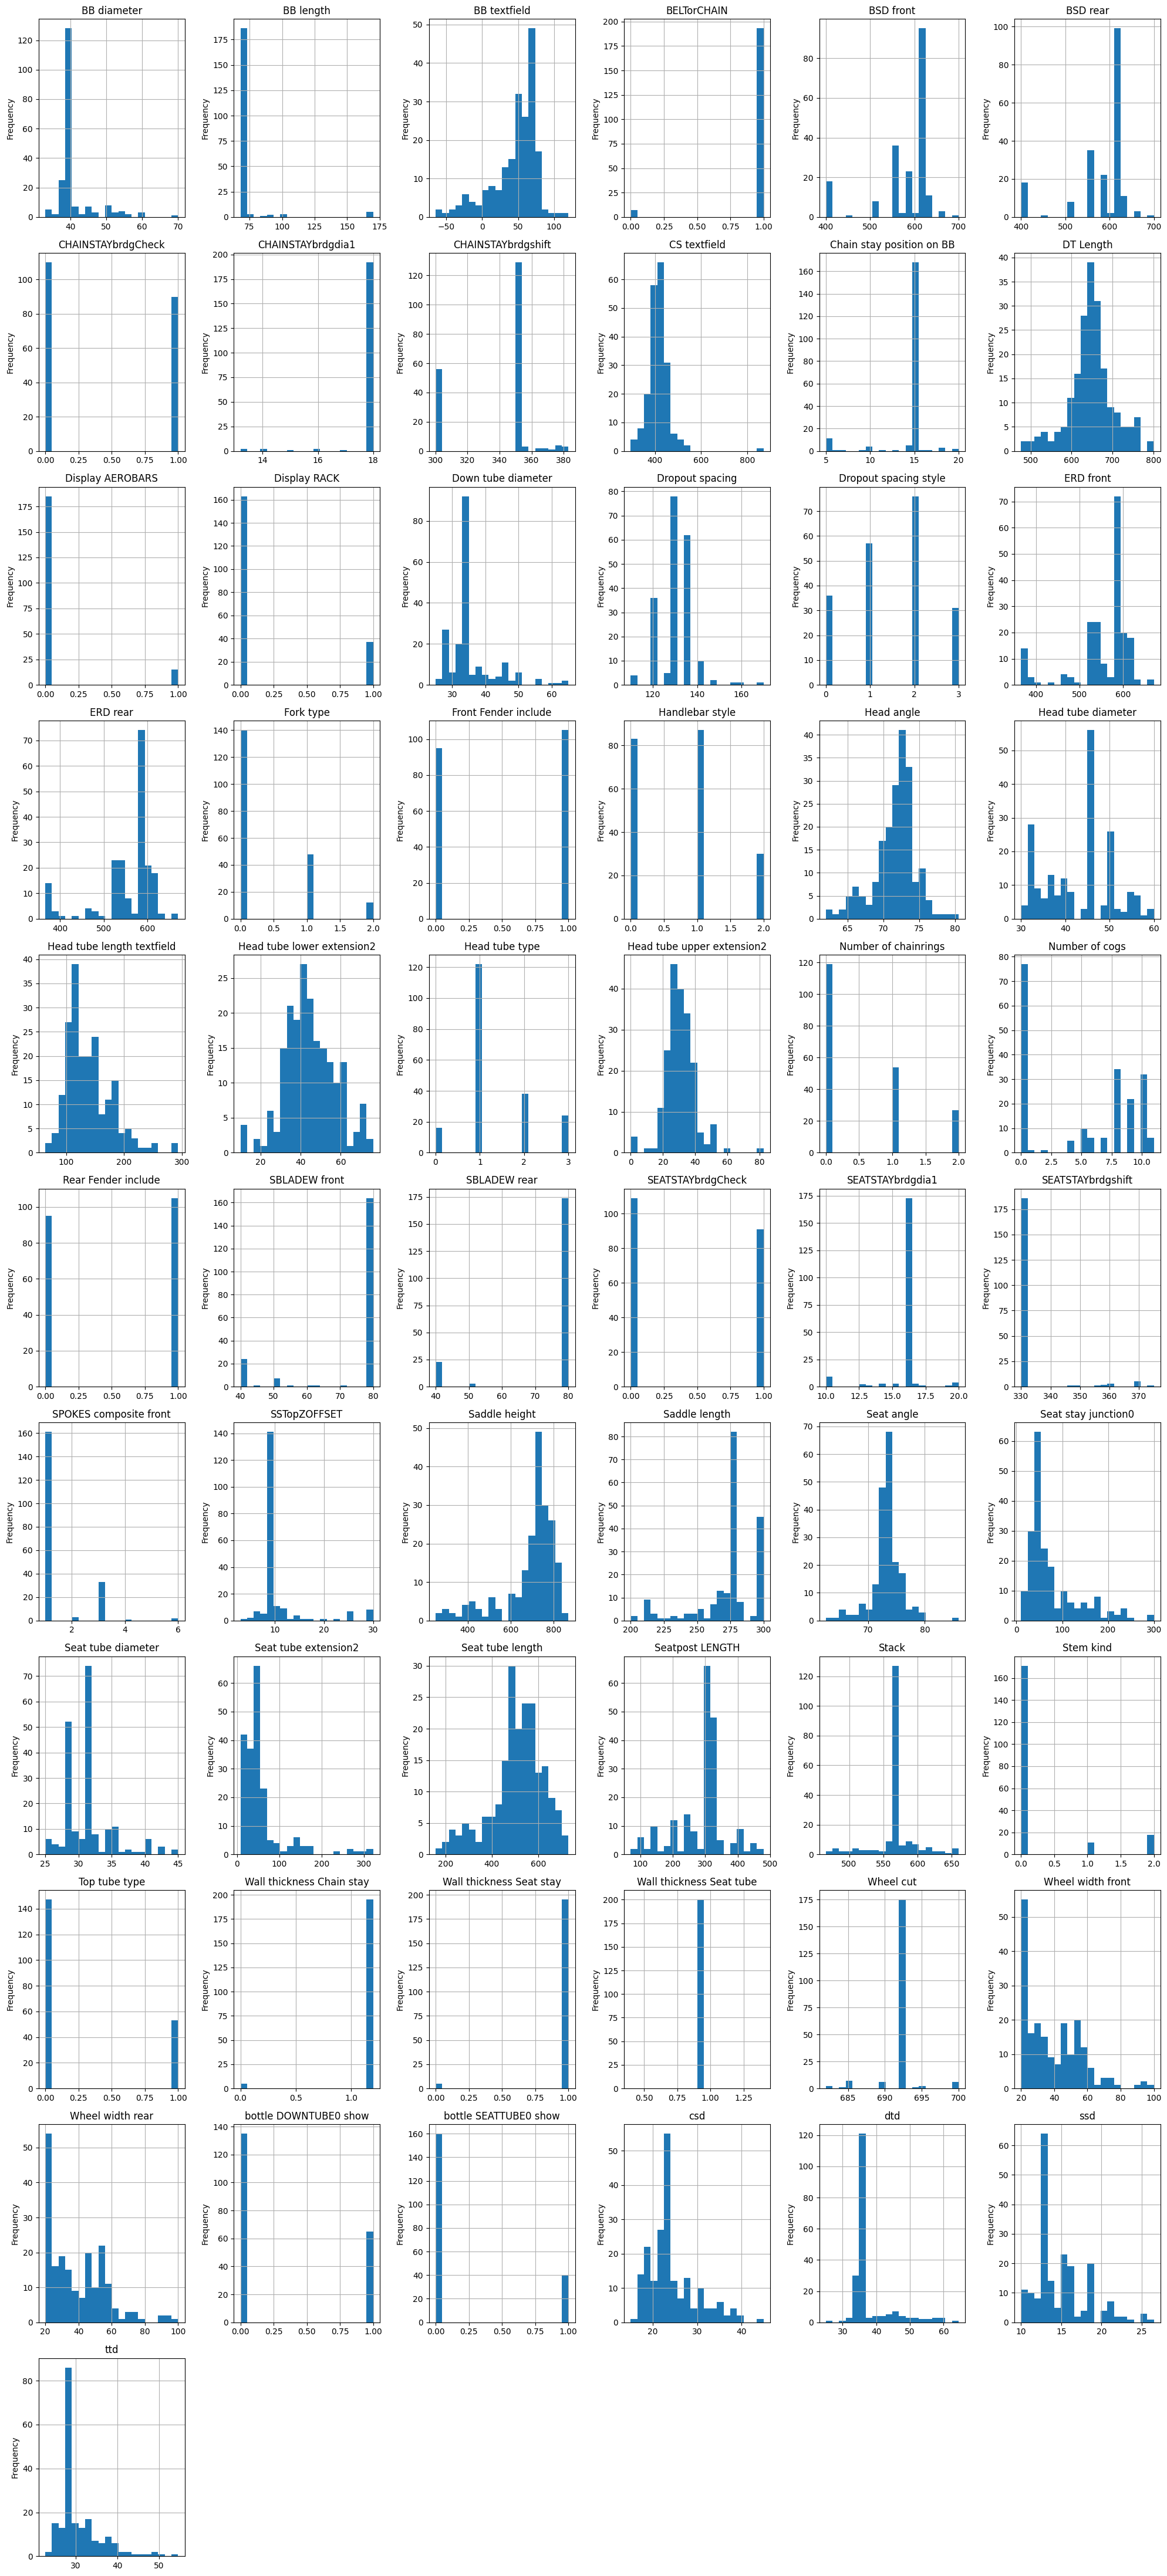

C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[col].dropna(), ax=axs[idx], shade=True)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[col].dropna(), ax=axs[idx], shade=True)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[col].dropna(), ax=axs[idx], shade=True)
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\95299714.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`

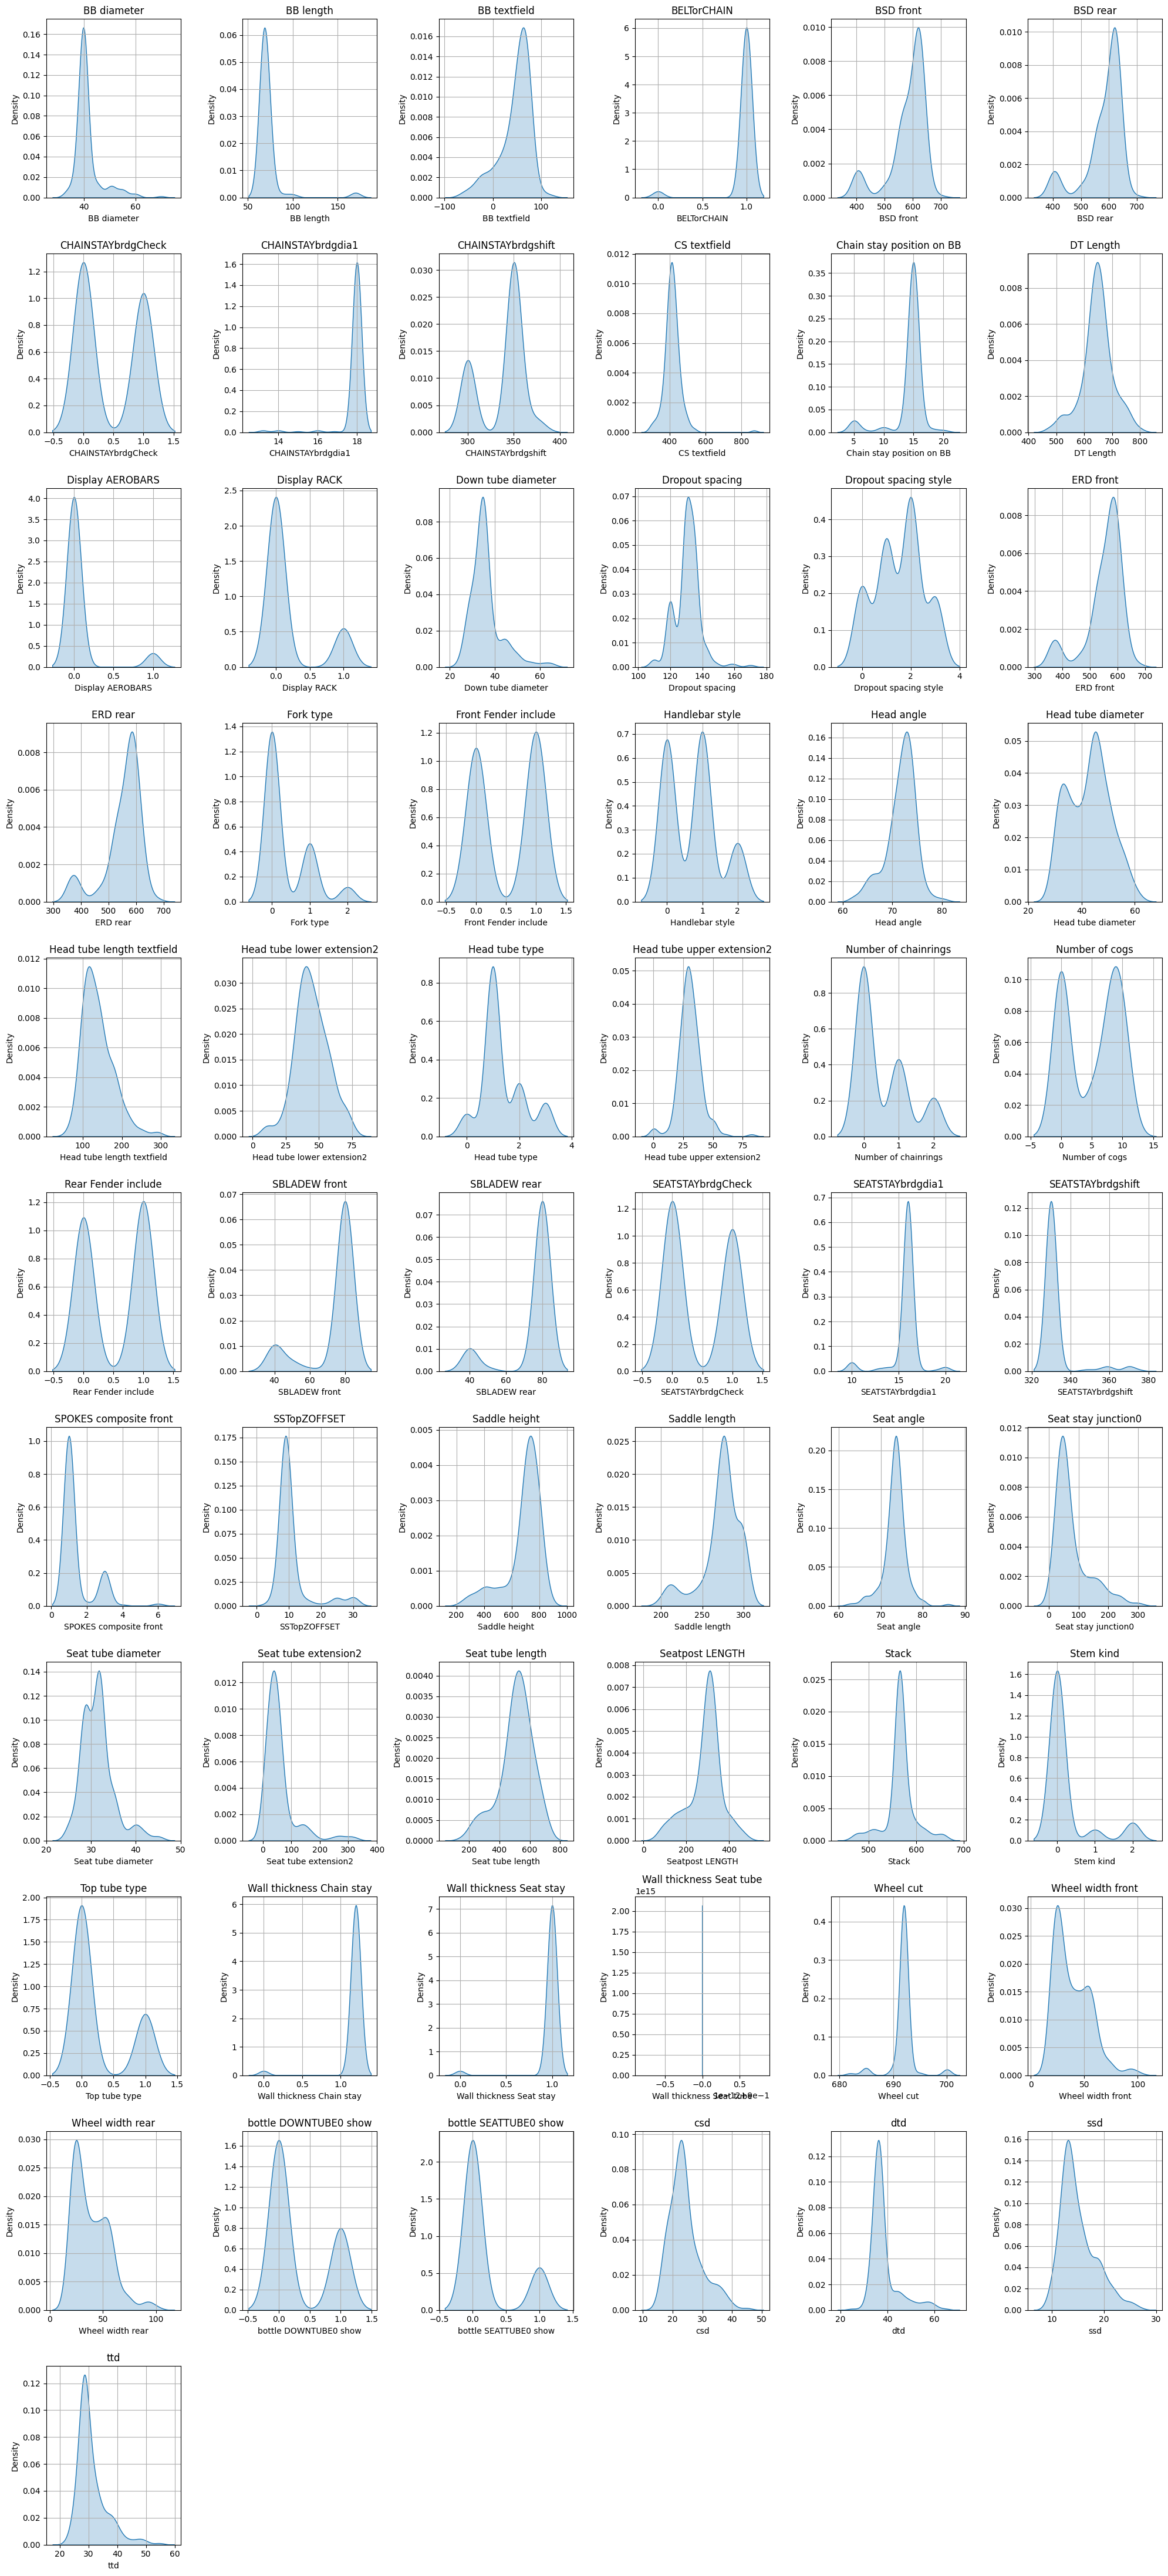

C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\1704292989.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_to_plot, labels=data_by_style.keys())
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\1704292989.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\1704292989.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_to_plot, labels=data_by_style.keys())
C:\Users\fabie\AppData\Local\Temp\ipykernel_22220\1704292989.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists 

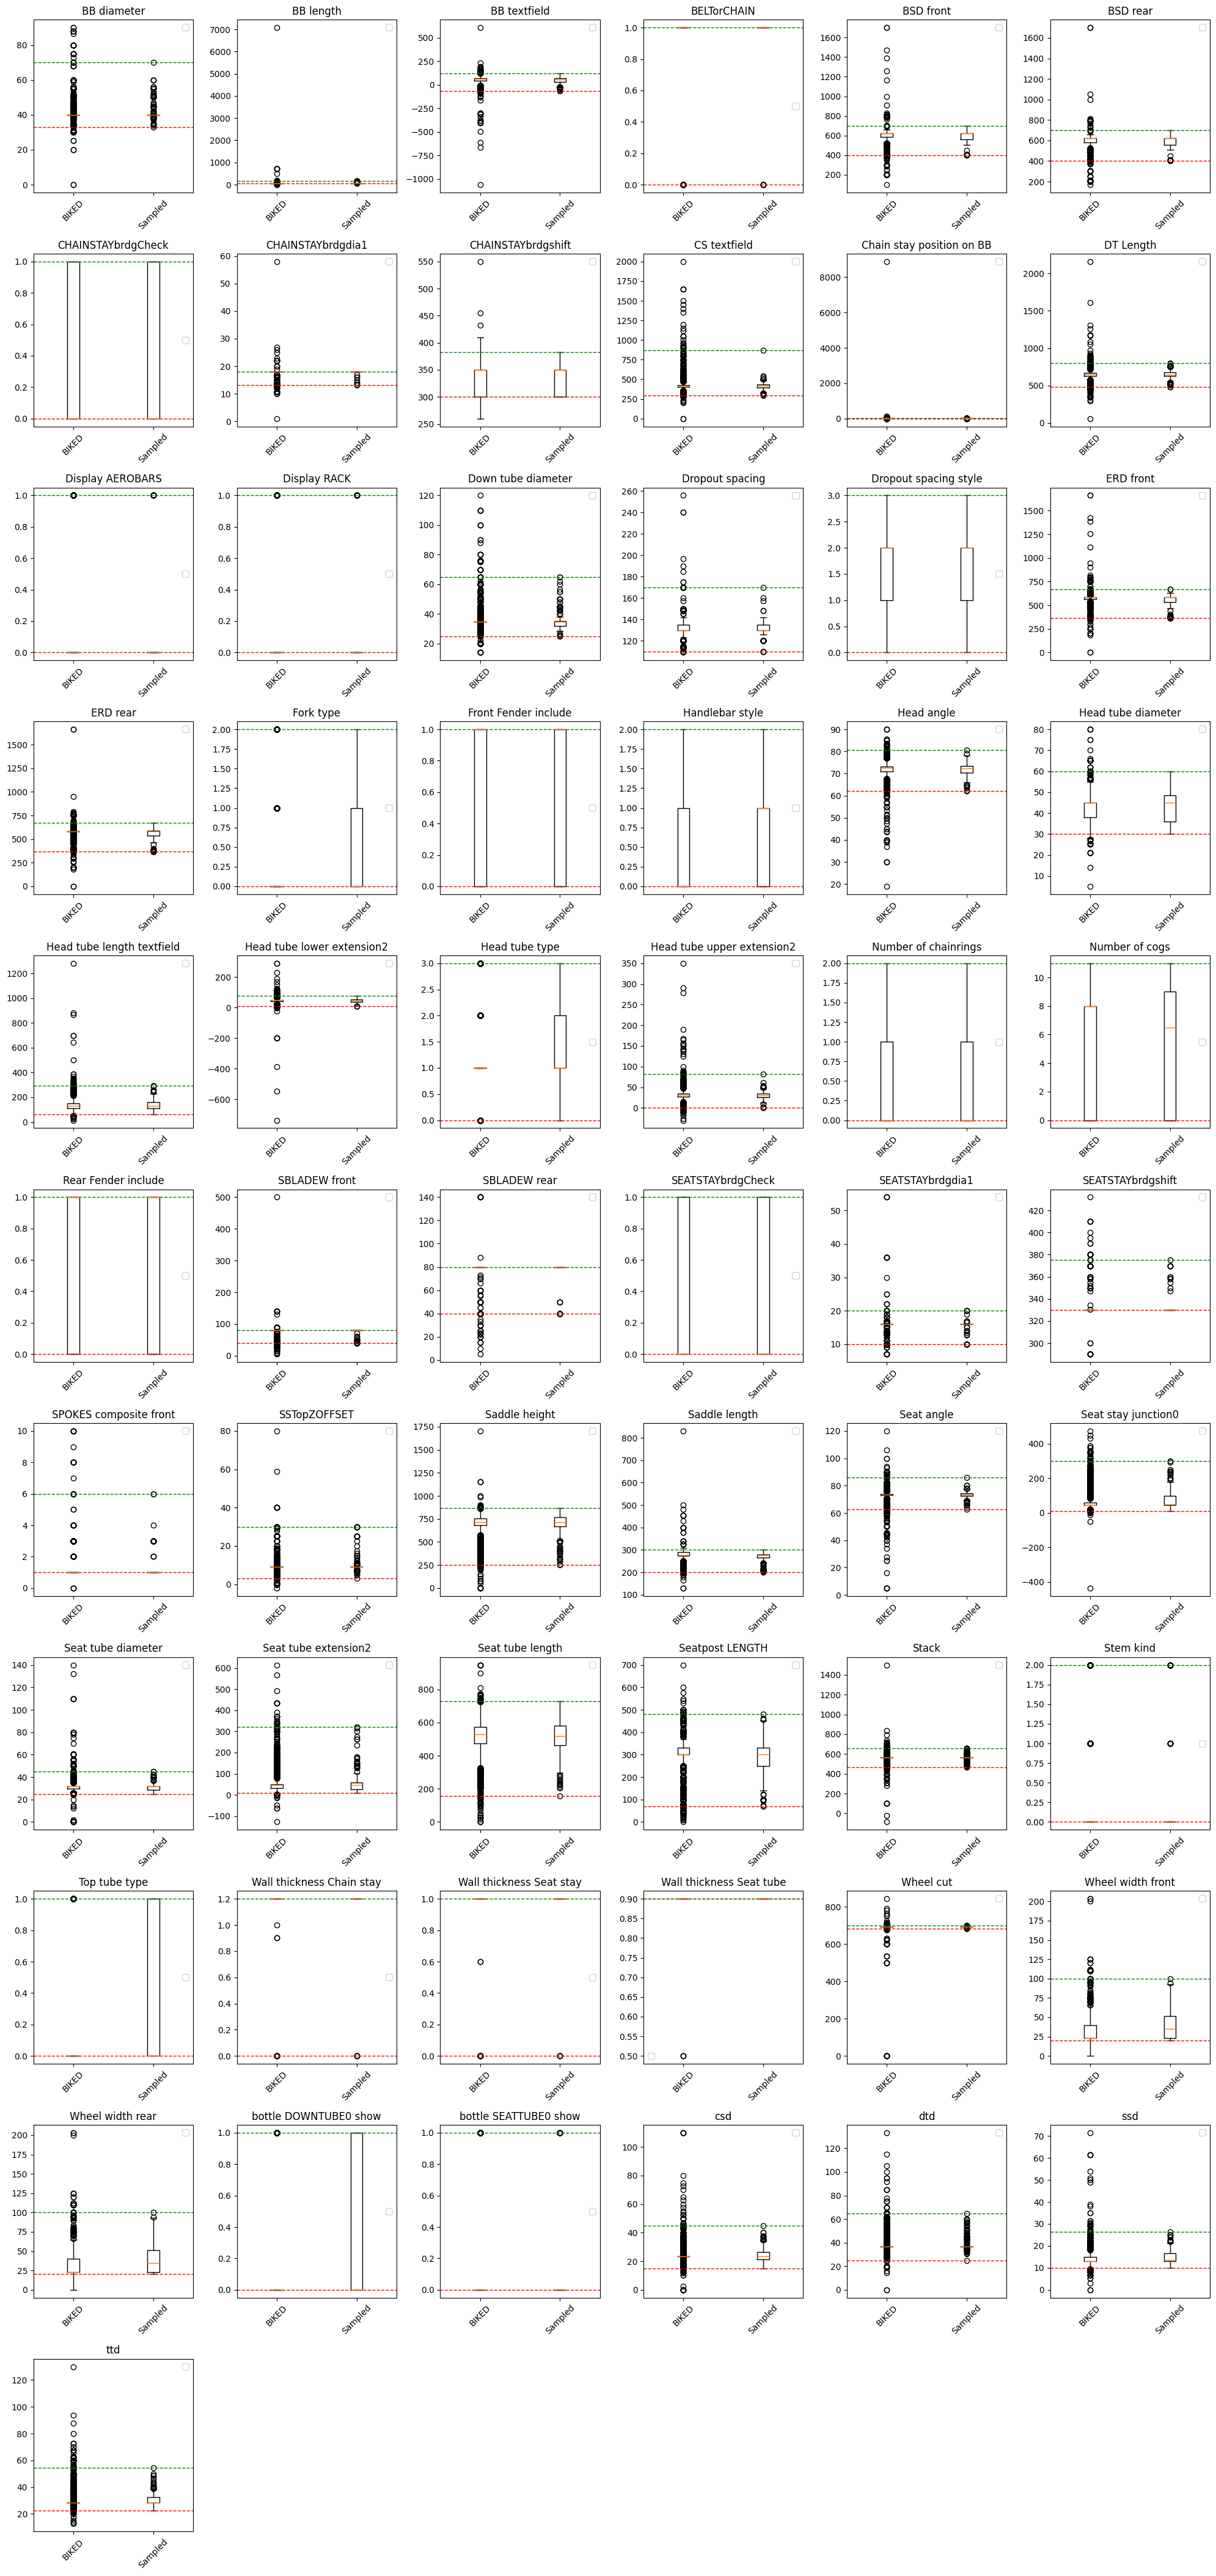

In [38]:
filtered_df, reduced_columns_from_bins = filter_features(sampled_df, 0.6, bins=20)
print(len(reduced_columns_from_bins))

plot_bins(sampled_df, 'big_comb_hist', bins=20)
plot_KDE(sampled_df, 'KDE_big_comb')

data_by_style = {}

data_by_style['BIKED'] = visual_df.select_dtypes(include=['number'])
data_by_style['Sampled'] = sampled_df.select_dtypes(include=['number'])

# data_by_style['Comb'] = visual_df.loc[list(combined_df.index)].select_dtypes(include=['number'])
# data_by_style['Comb+'] = visual_df.loc[list(big_combined_df_ids)].select_dtypes(include=['number'])


features = visual_df.select_dtypes(include=['number']).columns
num_features = len(features)
num_cols = 6  # Number of columns in the grid of subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed, rounding up

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    # Collect the data for each feature from each sampled style
    data_to_plot = [data_by_style[style][feature].dropna() for style in data_by_style]
    # data_to_plot = [filtered_bikes[style][feature].dropna() if style in filtered_bikes else [] for style in bike_dict.keys()]
    axes[i].boxplot(data_to_plot, labels=data_by_style.keys())
    axes[i].set_title(feature)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    # Add horizontal lines for the highest and lowest values
    if feature in limits.index:
        min_val = limits.loc[feature, 'min']
        max_val = limits.loc[feature, 'max']
        axes[i].axhline(min_val, color='r', linestyle='--', linewidth=1)
        axes[i].axhline(max_val, color='g', linestyle='--', linewidth=1)
        axes[i].legend()

# Hide any extra subplots that aren't needed
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../compair_comb_and_combPlus_dist.pdf', format='pdf')
plt.show()

In [ ]:


# # lists = os.listdir(Path(f"../Sampled/my_bikes/"))
# # my_bike_ids = []
# # for item in lists:
# #     my_bike_ids.append(int(re.sub(r"\D", "", item)))

# # print(my_bike_ids)
# # visual_df.pop("BIKESTYLE")
# # big_filtered_final_df = visual_df.loc[my_bike_ids].select_dtypes(include=['number'])

# # big_filtered_final_df= big_filtered_final_df.select_dtypes(include=['number'])
# # print(big_filtered_final_df.index)
# # numerical_df = visual_df.loc[big_distance_filtered_df].select_dtypes(include=['number'])

# data_by_style = {}
# # for style, bikes in bike_dict.items():
# #     filtered_by_style_df = visual_df.loc[list(bikes)].select_dtypes(include=['number'])
# #     data_by_style[style] = filtered_by_style_df
# data_by_style['All'] = visual_df.select_dtypes(include=['number'])
# # data_by_style['Comb'] = visual_df.loc[list(big_combined_df.index)].select_dtypes(include=['number'])
# # data_by_style['Comb+'] = visual_df.loc[list(bike_dict['ROAD'] or bike_dict['TOURING'] or bike_dict['TRACK']or bike_dict['CITY']or bike_dict['COMMUTER']or bike_dict['CYCLOCROSS'] or bike_dict['GRAVEL'] or bike_dict['MTB'] or bike_dict['POLO'] or bike_dict['TIMETRIAL'])].select_dtypes(include=['number'])

# # numerical_df = visual_df.loc[BIKED_sampled_ids_combined_300].select_dtypes(include=['number'])

# limits = big_filtered_final_df.agg(['min', 'max']).T

# features = visual_df.select_dtypes(include=['number']).columns
# num_features = len(features)
# num_cols = 6  # Number of columns in the grid of subplots
# num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed, rounding up

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
# axes = axes.flatten()  # Flatten the array of axes for easy iteration

# # Plot each feature in a separate subplot
# for i, feature in enumerate(features):
#     # Collect the data for each feature from each sampled style
#     data_to_plot = [data_by_style[style][feature].dropna() for style in data_by_style]
#     # data_to_plot = [filtered_bikes[style][feature].dropna() if style in filtered_bikes else [] for style in bike_dict.keys()]
#     axes[i].boxplot(data_to_plot, labels=data_by_style.keys())
#     axes[i].set_title(feature)
#     plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
#     # Add horizontal lines for the highest and lowest values
#     if feature in limits.index:
#         min_val = limits.loc[feature, 'min']
#         max_val = limits.loc[feature, 'max']
#         axes[i].axhline(min_val, color='r', linestyle='--', linewidth=1)
#         axes[i].axhline(max_val, color='g', linestyle='--', linewidth=1)
#         axes[i].legend()

# # Hide any extra subplots that aren't needed
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('../edited_big_comb_with_limits_dist.pdf', format='pdf')
# plt.show()
# # numerical_df = visual_df.loc[big_distance_filtered_df].select_dtypes(include=['number'])
# filtered_df, reduced_columns_from_bins = filter_features(big_combined_df, 0.6)
# print(len(reduced_columns_from_bins))

# plot_bins(big_combined_df, 'all_big_comb_hist')
# # Calculate min and max limits for each feature
# limits = big_filtered_final_df.agg(['min', 'max']).T
# limits.columns = ['min', 'max']

# # Function to check if a row is outside the limits
# def is_outside_limits(row, limits):
#     for feature in limits.index:
#         if row[feature] < limits.loc[feature, 'min'] or row[feature] > limits.loc[feature, 'max']:
#             return True
#     return False

# # Apply the function to each row in visual_df
# outside_limits = visual_df.apply(lambda row: is_outside_limits(row, limits), axis=1)

# # Filter rows that fall outside the limits
# outside_limits_df = visual_df[outside_limits]

# # print("Rows outside limits:")
# # print(outside_limits_df)
# reduced_df =pd.read_csv("BIKED_reduced.csv", index_col=0)
# temp = reduced_df.loc[outside_limits_df.index]
# temp = temp['BIKESTYLE']

# # Calculate counts of bikes outside limits by BIKESTYLE
# outside_counts = temp.value_counts()

# # Calculate total counts of bikes by BIKESTYLE
# total_counts = reduced_df['BIKESTYLE'].value_counts()

# # Calculate percentage outside limits for each BIKESTYLE
# percentage_outside_limits = (outside_counts / total_counts) * 100

# print("Percentage of bikes outside limits by BIKESTYLE:")
# print(percentage_outside_limits)
# ids = big_filtered_final_df.index
# print(list(ids))
